In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc

import CHLpredictor as chl

CLOSE_IND = 0
CLOSE_RATIO_IND = 1
LOW_RATIO_IND = 2
HIGH_RATIO_IND = 3
VOLUME_RATIO_IND = 4

OUT_VALUE = CLOSE_IND

ticker = 'AMZN'

data = pd.read_csv(ticker + '.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

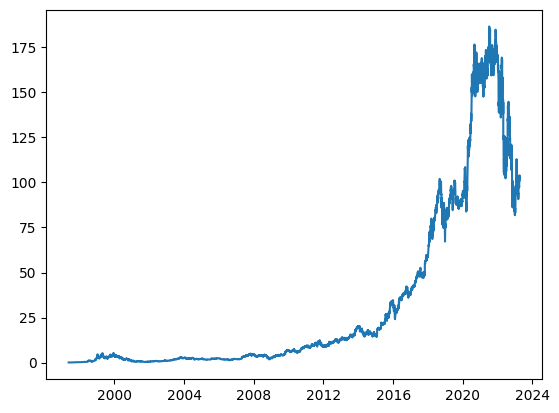

In [3]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [4]:
lookback = 7
df1, df2, df3, df4, df5 = chl.prepare_dataframe_for_lstm_with_date(data, lookback)
df5



,Volume,Volume(t-1),Volume(t-2),Volume(t-3),Volume(t-4),Volume(t-5),Volume(t-6),Volume(t-7)
Date,,,,,,,,
1997-05-27,173952000.0,318744000.0,235536000.0,377064000.0,109344000.0,122136000.0,294000000.0,1.443120e+09
1997-05-28,91488000.0,173952000.0,318744000.0,235536000.0,377064000.0,109344000.0,122136000.0,2.940000e+08
1997-05-29,69456000.0,91488000.0,173952000.0,318744000.0,235536000.0,377064000.0,109344000.0,1.221360e+08
1997-05-30,51888000.0,69456000.0,91488000.0,173952000.0,318744000.0,235536000.0,377064000.0,1.093440e+08
1997-06-02,11832000.0,51888000.0,69456000.0,91488000.0,173952000.0,318744000.0,235536000.0,3.770640e+08
...,...,...,...,...,...,...,...,...
2023-03-29,49783300.0,38720100.0,46721300.0,56095400.0,57559300.0,57475400.0,58597300.0,6.238890e+07
2023-03-30,53633400.0,49783300.0,38720100.0,46721300.0,56095400.0,57559300.0,57475400.0,5.859730e+07
2023-03-31,56704300.0,53633400.0,49783300.0,38720100.0,46721300.0,56095400.0,57559300.0,5.747540e+07


In [5]:
df1_np = df1.to_numpy()
df2_np = df2.to_numpy()
df3_np = df3.to_numpy()
df4_np = df4.to_numpy()
df5_np = df5.to_numpy()

df1_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.03290001e+02, 1.02000000e+02, 1.00250000e+02, ...,
        9.81299970e+01, 9.87099990e+01, 9.86999970e+01],
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01]])

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))
scaler3 = MinMaxScaler(feature_range=(-1, 1))
scaler4 = MinMaxScaler(feature_range=(-1, 1))
scaler5 = MinMaxScaler(feature_range=(-1, 1))
df1_np_scaled = scaler1.fit_transform(df1_np)
df2_np_scaled = scaler2.fit_transform(df2_np)
df3_np_scaled = scaler3.fit_transform(df3_np)
df4_np_scaled = scaler4.fit_transform(df4_np)
df5_np_scaled = scaler5.fit_transform(df5_np)

scaler = [scaler1, scaler2, scaler3, scaler4, scaler5]

df1_np_scaled

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.10690997,  0.09307615,  0.07431453, ...,  0.05158   ,
         0.05779984,  0.05769258],
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ]])

In [7]:
# X = np.array([df1_np[:, 1:], df2_np[:, 1:], df3_np[:, 1:], df4_np[:, 1:]])
# y = np.array([df1_np[:, 0], df2_np[:, 0], df3_np[:, 0], df4_np[:, 0]])

X = np.zeros((len(df1_np), 5 * lookback))
y = np.zeros((len(df1_np), 3))
for i in range(0,len(df1_np)):
    X[i] = np.hstack((df1_np_scaled[i,1:], df2_np_scaled[i,1:], df3_np_scaled[i,1:], df4_np_scaled[i,1:], df5_np_scaled[i,1:]))
    y[i] = np.hstack((df1_np_scaled[i,0], df3_np_scaled[i,0], df4_np_scaled[i,0]))

X.shape, y.shape

((6508, 35), (6508, 3))

In [8]:
X = dc(np.flip(X, axis=1)) #flip left right
X

array([[ 0.38034321, -0.72626105, -0.89176634, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.72626105, -0.89176634, -0.90408505, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.89176634, -0.90408505, -0.6462703 , ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [-0.95403459, -0.9539538 , -0.95536353, ...,  0.04203581,
         0.07431453,  0.09307615],
       [-0.9539538 , -0.95536353, -0.96439081, ...,  0.07431453,
         0.09308121,  0.10690997],
       [-0.95536353, -0.96439081, -0.97209597, ...,  0.09308121,
         0.10691495,  0.09747299]])

In [9]:
split_index = int(len(X) * 0.95)

split_index

6182

In [10]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6182, 35), (326, 35), (6182, 3), (326, 3))

In [11]:
X_train = X_train.reshape((-1, lookback*5, 1))
X_test = X_test.reshape((-1, lookback*5, 1))

y_train = y_train.reshape((-1, 3))
y_test = y_test.reshape((-1, 3))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6182, 35, 1), (326, 35, 1), (6182, 3), (326, 3))

In [12]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6182, 35, 1]),
 torch.Size([326, 35, 1]),
 torch.Size([6182, 3]),
 torch.Size([326, 3]))

In [13]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [14]:
train_dataset

In [15]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 35, 1]) torch.Size([16, 3])


In [17]:
from CHLpredictor import CHLpredictor

model = CHLpredictor(device, 1, 5, 1, 3)
model.to(device)
model

CHLpredictor(
  (model): GRU(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=3, bias=True)
)

In [18]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss_across_batches = running_loss / len(train_loader)
    print('Train Loss: {0:.3f}'.format(avg_loss_across_batches))

In [19]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            writer.add_scalar("Loss/train", loss, epoch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [21]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss() #chl.CHLLoss() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    
torch.save(model, "checkpoints/CHLpredictor_" + ticker + ".pt")
writer.flush()
writer.close()

Epoch: 1
Train Loss: 0.065
Val Loss: 0.018
***************************************************

Epoch: 2
Train Loss: 0.018
Val Loss: 0.011
***************************************************

Epoch: 3
Train Loss: 0.009
Val Loss: 0.008
***************************************************

Epoch: 4
Train Loss: 0.008
Val Loss: 0.008
***************************************************

Epoch: 5
Train Loss: 0.008
Val Loss: 0.007
***************************************************

Epoch: 6
Train Loss: 0.008
Val Loss: 0.007
***************************************************

Epoch: 7
Train Loss: 0.008
Val Loss: 0.007
***************************************************

Epoch: 8
Train Loss: 0.008
Val Loss: 0.007
***************************************************

Epoch: 9
Train Loss: 0.008
Val Loss: 0.007
***************************************************

Epoch: 10
Train Loss: 0.007
Val Loss: 0.007
***************************************************


(6182, 3)


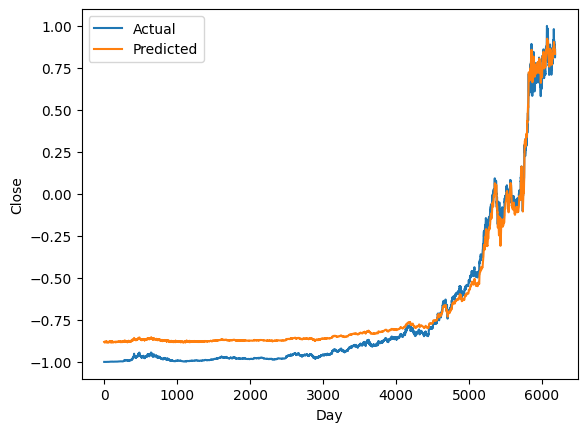

In [22]:
model = torch.load("checkpoints/CHLpredictor_" + ticker + ".pt")
model.eval()

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

print(predicted.shape)

plt.plot(y_train[:,OUT_VALUE], label='Actual')
plt.plot(predicted[:,OUT_VALUE], label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


# Translate back to real prices

In [42]:
OUT_VALUE = CLOSE_RATIO_IND
train_predictions = predicted[:,OUT_VALUE].flatten()
print(train_predictions.shape, X_train.shape)

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions

dummies = scaler[OUT_VALUE].inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

(6182,) torch.Size([6182, 35, 1])


array([0.03345768, 0.03347433, 0.03348127, ..., 0.02510285, 0.02515743,
       0.02515213])

In [43]:
X_train.shape, y_train.shape

(torch.Size([6182, 35, 1]), torch.Size([6182, 3]))

In [44]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train[:, OUT_VALUE].flatten()
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 0.00071911, -0.00053166,  0.01795098, ...,  0.01668673,
        0.01160337,  0.00420238])

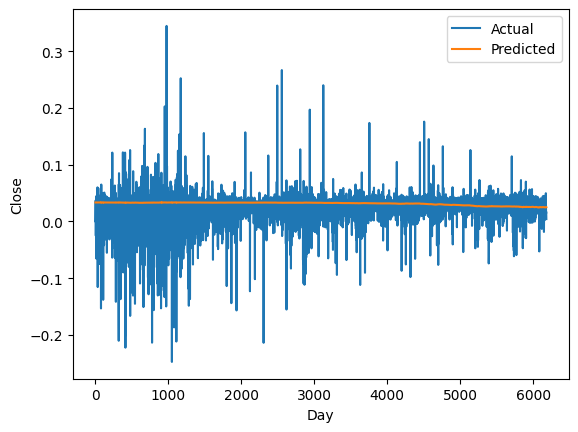

In [45]:
plt.plot(new_y_train, label='Actual')
plt.plot(train_predictions, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [46]:
test_predictions_all = model(X_test.to(device)).detach().cpu().numpy()
test_predictions = test_predictions_all[:,OUT_VALUE].flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([0.02512866, 0.02518813, 0.02520928, 0.02523934, 0.02519403,
       0.02517435, 0.02517819, 0.02519209, 0.0251879 , 0.02521083,
       0.0252369 , 0.02525116, 0.02522422, 0.02528643, 0.02535872,
       0.02539955, 0.02543396, 0.02543616, 0.02538307, 0.02540981,
       0.02547206, 0.02549007, 0.02556332, 0.02565289, 0.02581798,
       0.02599342, 0.02599128, 0.02606245, 0.0260634 , 0.02600833,
       0.02589435, 0.02579892, 0.02579266, 0.02590327, 0.02601854,
       0.02569132, 0.02562854, 0.02557436, 0.02558189, 0.02564869,
       0.02572148, 0.02566818, 0.02562953, 0.02562549, 0.0257014 ,
       0.02576457, 0.02584774, 0.02590602, 0.02577396, 0.02572465,
       0.02574845, 0.02579127, 0.02580709, 0.02588849, 0.02598572,
       0.02614308, 0.02613021, 0.02599361, 0.02585984, 0.02591564,
       0.02597187, 0.02585128, 0.02572964, 0.02564238, 0.02557874,
       0.02554441, 0.02548183, 0.02546956, 0.02543907, 0.02537865,
       0.02529689, 0.02529057, 0.02534953, 0.02540441, 0.02537

In [47]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test[:,OUT_VALUE].flatten()
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 1.57518743e-02,  8.35551784e-03,  2.76013946e-02,  2.46415738e-02,
        3.13386116e-02,  2.50991688e-02,  3.35917585e-02,  2.37268604e-02,
        3.26480868e-02,  2.34002259e-02,  3.33810719e-02,  1.07717106e-02,
        1.61904206e-02,  2.07978064e-02,  2.87909519e-02, -5.41792958e-03,
        3.17012716e-02,  3.07544034e-02,  9.53626134e-03,  2.73802501e-02,
        6.57837812e-03,  1.85196976e-02,  2.08421488e-03, -3.28595749e-02,
       -1.94177956e-02, -1.18549342e-02,  1.60109972e-02,  4.08699289e-02,
        2.35522809e-02,  3.95454527e-02,  2.26917017e-02,  2.00389193e-02,
       -5.30327105e-02,  1.30693534e-01,  3.43393591e-02,  2.03811424e-02,
        2.91038868e-02,  1.34881934e-02, -6.50570202e-03,  2.52213729e-02,
        3.32986316e-02,  2.45293708e-02,  1.19020736e-02,  1.02047658e-02,
        7.26187540e-03, -3.74069899e-03, -3.57911074e-03,  2.14118655e-02,
        1.59536235e-02,  1.12627293e-02,  1.95798038e-02, -6.99024859e-04,
        6.49712057e-03, -

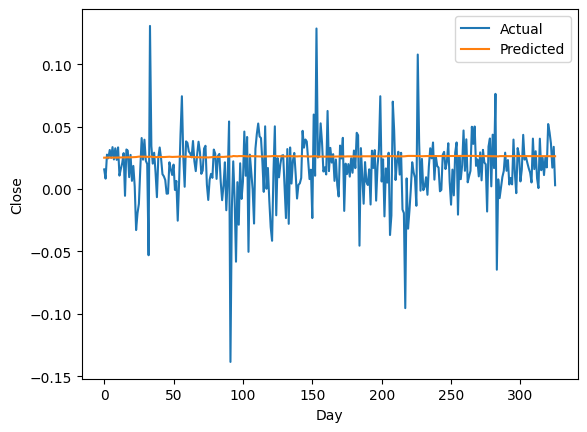

In [48]:
plt.plot(new_y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


Root Mean Square Error:  7.489943274362701 %
Std: 19.80894325650483 %


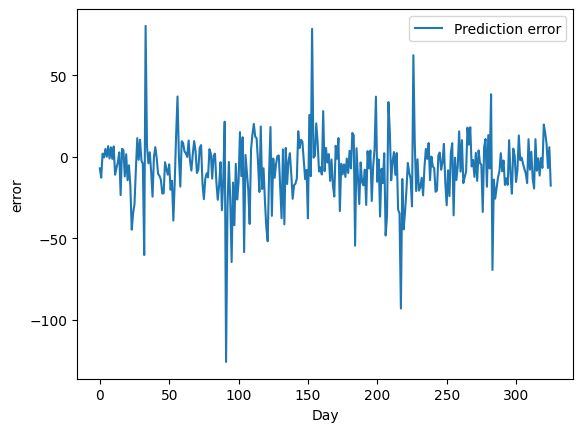

In [49]:
import math

MSE = np.square(np.subtract(new_y_test,test_predictions).mean()) 
RMSE = math.sqrt(MSE)
RMSE_pec = RMSE / new_y_test.max() * 100
print("Root Mean Square Error: ", RMSE_pec, "%")

print("Std:", np.subtract(new_y_test,test_predictions).std()/new_y_test.max()*100, "%")

plt.plot(np.subtract(new_y_test,test_predictions)/new_y_test.max()*100, label='Prediction error')
plt.xlabel('Day')
plt.ylabel('error')
plt.legend()
plt.show()

In [50]:
bad = [index for index,value in enumerate(test_predictions_all) if value[1] > value[0]]
bad = bad + [index for index,value in enumerate(test_predictions_all) if value[2] < value[0]]
test_predictions_all[bad]

array([[-0.08021594, -0.07433722, -0.444988  ],
       [-0.07675844, -0.07445214, -0.44390166],
       [-0.08441672, -0.07416584, -0.44356006],
       ...,
       [ 0.05950592, -0.07517987, -0.44620013],
       [ 0.07490207, -0.07515644, -0.44615728],
       [ 0.08289763, -0.07506717, -0.44682282]], dtype=float32)